# Relocate the folder, import libraries

In [1]:
import os
current_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

import sys
sys.path.append(parent_dir)

In [2]:
import idx2numpy
import numpy as np

#from torchvision import transforms
from torchvision.transforms import v2 # for torchvision > 0.15
import torch.nn as nn
import torcheval.metrics as metrics

%matplotlib inline 
import matplotlib.pyplot as plt

from utils.dataloaders import *
from utils.preprocessing import *
from sparse_autoencoder.custom_training_utils import *
from utils.metrics import *
from utils.losses import *

from sparse_autoencoder.models import *
from datetime import date

/home/data/Generative_AI/Generative_AI/sparse_autoencoder/custom_training_utils.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Load datasets

In [3]:
data_dir = "../datasets/MNIST"

In [4]:
train_images = idx2numpy.convert_from_file(os.path.join(data_dir, "train", "train-images-idx3-ubyte"))
train_labels = idx2numpy.convert_from_file(os.path.join(data_dir, "train", "train-labels-idx1-ubyte"))
test_images = idx2numpy.convert_from_file(os.path.join(data_dir, "test", "t10k-images-idx3-ubyte"))
test_labels = idx2numpy.convert_from_file(os.path.join(data_dir, "test", "t10k-labels-idx1-ubyte"))

In [5]:
# Data stats
print("[INFO]: Training set shape: {}".format(train_images.shape))
print("[INFO]: Test set shape: {}".format(test_images.shape))
print("[INFO]: Training label shape: {}".format(train_labels.shape))
print("[INFO]: Test label shape: {}".format(test_labels.shape))

[INFO]: Training set shape: (60000, 28, 28)
[INFO]: Test set shape: (10000, 28, 28)
[INFO]: Training label shape: (60000,)
[INFO]: Test label shape: (10000,)


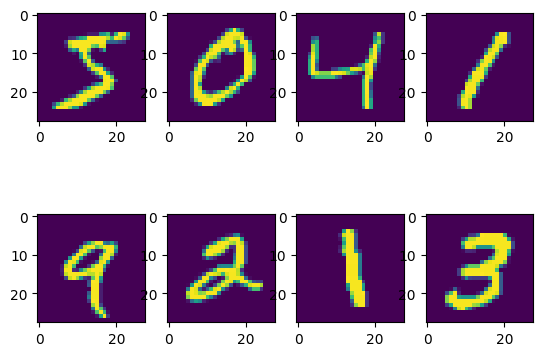

In [6]:
# Visualize the first few images for checking
fig, axes = plt.subplots(nrows=2, ncols=4)
for i in range(8):
    image = train_images[i, :, :]
    axes[int(i/4), i%4].imshow(image)
plt.show()

# Preprocessing Data

In [7]:
# Image scaling
train_images = train_images/255
test_images = test_images/255

# Calculate mean and std
mean = np.mean(train_images)
std = np.std(train_images)

In [8]:
train_transform = v2.Compose([
    v2.ToTensor(), # deprecated
    Flatten(),
    Linear_Normalize(mean, std),
    v2.ToDtype(torch.float32, scale=False),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
train_dataset = MnistDataset(images=train_images, labels=train_labels, transforms=train_transform)
test_dataset = MnistDataset(images=test_images, labels=test_labels, transforms=train_transform)

# Define training configurations

In [10]:
# Model configuration
in_features = 784
enc_hidden_features = [256, 128]
emb_features = 64
dec_hidden_features = [128, 256]

# Training configuration
epochs = 25
batchsize = 128
learning_rate = 0.001
num_workers = 4
device = "cuda"
use_wandb = True
use_tensorboard = True

# Sprase Autoencoder Loss configuration
beta = 1.0
rho = 0.05

# Checkpoint dir
save_dir = "../checkpoints"
exp_name = "linear_sparse_autoencoder_{}".format(str(date.today()))
save_dir = os.path.join(save_dir, exp_name)
if not os.path.exists(save_dir):
    os.system("mkdir {}".format(save_dir))

In [11]:
train_loader = get_loader(train_dataset, batchsize, num_workers, shuffle=True, drop_last=False)
test_loader = get_loader(test_dataset, batchsize, num_workers, shuffle=False, drop_last=False)

In [12]:
model = Linear_AutoEncoder(in_features, enc_hidden_features, emb_features, dec_hidden_features)

In [13]:
loss_func = SparseAutoencoderLoss(beta=beta, rho=rho, device=device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
metrics = [
    # The first thre metrics only work on images
    #metrics.FrechetInceptionDistance(device=device),
    #metrics.StructuralSimilarity(device=device),
    #metrics.PeakSignalNoiseRatio(device=device),
    metrics.MeanSquaredError(device=device)
]
metric_weights = [1.0]

In [16]:
if use_wandb:
    # initialize wandb for usage
    wandb.login()
    wandb.init(
        # Set the project where this run will be logged
        project="linear-mnist-sparse-autoencoder", 
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name=exp_name, 
        # Track hyperparameters and run metadata
        config={
            "learning_rate": learning_rate,
            "architecture": str(model.__class__.__name__),
            "dataset": "MNIST",
            "epochs": epochs,
        })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: quyenobest2000. Use `wandb login --relogin` to force relogin


In [17]:
train_epochs(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    loss_func=loss_func,
    metrics=metrics,
    metric_weights=metric_weights,
    device=device,
    num_epochs=epochs,
    log_rate=5,
    save_rate=10,
    save_dir=save_dir,
    use_tensorboard=use_tensorboard,
    use_wandb=use_wandb,
    interval=0
)

torch.Size([128, 784])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 64]           8,256
    Linear_Encoder-4                   [-1, 64]               0
            Linear-5                  [-1, 128]           8,320
            Linear-6                  [-1, 256]          33,024
            Linear-7                  [-1, 784]         201,488
    Linear_Decoder-8                  [-1, 784]               0
Total params: 484,944
Trainable params: 484,944
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.85
Estimated Total Size (MB): 1.87
----------------------------------------------------------------
[INFO]: Epoch: 1/25

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
469it [00:03, 148.32it/s]


[INFO]: Training Results:
Training loss: -53056.14362455895
Train_MeanSquaredError: 0.8362694978713989
[INFO]: Validating ...


79it [00:00, 221.44it/s]


[INFO]: Sleeping for 15 secs ...
[INFO]: Epoch: 2/25


469it [00:03, 155.76it/s]

[INFO]: Training Results:
Training loss: -877112.3111340618
Train_MeanSquaredError: 0.8300072550773621
[INFO]: Validating ...



79it [00:00, 236.78it/s]


[INFO]: Sleeping for 15 secs ...
[INFO]: Epoch: 3/25


273it [00:01, 151.10it/s]


KeyboardInterrupt: 